# **<h1><center> Production EDA </center></h1>**

## Import Packages

In [2]:
import pandas as pd
import sqlite3
import plotly.io as pio
import numpy as np
pd.set_option('display.max_columns', None)
from statistics import mean 
import plotly.express as px
import plotly.graph_objects as go
pd.options.display.float_format = '{:.3f}'.format
pd.set_option("display.max_rows",1000)
pd.options.display.precision = 1

### Connect to SQlite3 DataBase

In [3]:
%load_ext sql
%sql sqlite:////Users/john.odonnell/Python/Web_Scraping/NDIC/Well_DataBase.db

### View Tables

In [4]:
%%sql 

SELECT 
    name 
FROM sqlite_master 
WHERE type ='table';

 * sqlite:////Users/john.odonnell/Python/Web_Scraping/NDIC/Well_DataBase.db
Done.


[('prod_table',),
 ('header_table',),
 ('prod_table_clean',),
 ('header_table_clean',)]

## Import Production data

In [5]:
query = %sql SELECT * FROM prod_table_clean WHERE Days > 0

df_production = query.DataFrame()
df_production.set_index('UWI',inplace=True)
df_production['Date'] = pd.to_datetime(df_production['Date'], infer_datetime_format=True)
df_production.describe().transpose()

 * sqlite:////Users/john.odonnell/Python/Web_Scraping/NDIC/Well_DataBase.db
Done.


count     mean       std   min      25%      50%      75%  \
Days      1164366.000   27.513     6.523 1.000   28.000   30.000   31.000   
Oil_nrm   1164261.000 3725.619  9875.729 0.000 1020.912 1951.001 3942.026   
Water_nrm 1164261.000 3307.051  9707.993 0.000  729.730 1573.477 3327.820   
Gas_nrm   1164261.000 6017.724 26479.178 0.000 1322.174 2823.785 5975.393   
Fluid_nrm 1164261.000 7032.670 18349.463 0.000 2114.230 3789.857 7314.958   
WOR       1160455.000      inf       NaN 0.000    0.417    0.844    1.524   
GOR       1161959.000      inf       NaN 0.000    0.871    1.371    2.226   

                  max  
Days           31.000  
Oil_nrm   3446710.526  
Water_nrm 2614736.842  
Gas_nrm   7422894.737  
Fluid_nrm 5155263.158  
WOR               inf  
GOR               inf

## Import Header data

In [7]:
query = %sql SELECT * FROM header_table_clean

df_header = query.DataFrame()

# Set Index and view shape
df_header.set_index('UWI',inplace=True)
df_header[['Completion_Date','Spud_Date']] = df_header[['Completion_Date','Spud_Date']].apply(pd.to_datetime, errors='coerce')
df_header.sample(3)

 * sqlite:////Users/john.odonnell/Python/Web_Scraping/NDIC/Well_DataBase.db
Done.


File_Number                 Well_Name Well_Type Well_Status  \
UWI                                                                           
33053034640000        20382  WISNESS 152-96-28A-33-1H        OG           A   
33025024770000        27754     CCU OLYMPIAN 44-35TFH        OG           A   
33105025020000        22243     MARTIN FEDERAL 16-21H        OG           A   

                      Location  Latitude  Longitude  \
UWI                                                   
33053034640000  SESE 21-152-96    47.964   -102.968   
33025024770000  SESE 35-147-94    47.503   -102.611   
33105025020000  SESW 9-153-102    48.083   -103.809   

                                         Current_Operator Completion_Date  \
UWI                                                                         
33053034640000                         PETRO-HUNT, L.L.C.      2011-09-04   
33025024770000  BURLINGTON RESOURCES OIL & GAS COMPANY LP      2014-09-08   
33105025020000          OASIS PETROLEUM NORTH AMERICA LLC      2012-05-05   

               Total_Depth  Spud_Date Perf_Interval  Cum_Oil  Cum_Gas  \
UWI                                                                     
33053034640000       20796 2011-06-13   10929-20796   540927  1233051   
33025024770000       20607 2014-04-02   11221-20607   291192   123080   
33105025020000       20478 2012-03-08   10842-20478   308129   202695   

                Cum_Water  Vintage_Year  Top_Perf  Bottom_Perf     Operator  \
UWI                                                                           
33053034640000     137136      2011.000 10929.000    20796.000  PETRO-HUNT,   
33025024770000     196563      2014.000 11221.000    20607.000   BURLINGTON   
33105025020000     434027      2012.000 10842.000    20478.000        OASIS   

                Perforated_Length Direction        TRS Section Township Range  \
UWI                                                                             
33053034640000           9867.000      SESE  21-152-96      21      152    96   
33025024770000           9386.000      SESE  35-147-94      35      147    94   
33105025020000           9636.000      SESW  9-153-102       9      153   102   

                 Block  12m_Oil_nrm_cum  12m_WOR  24m_Oil_nrm_cum  24m_WOR  \
UWI                                                                          
33053034640000   15296       191645.000    0.180       271277.000    0.559   
33025024770000   14794       117532.000    0.758       186830.000    0.463   
33105025020000  153102        83971.000    1.390       130885.000    1.336   

                36m_Oil_nrm_cum  36m_WOR  
UWI                                       
33053034640000       365024.000    0.259  
33025024770000       232536.000    0.649  
33105025020000       178631.000    1.575

## Define Functions

In [8]:
def STREAM_PLOT(dataframe, production_dataframe, material, width, height, variable_dict = {'0-99999999':None}, rate_cum = 0, averages = 0, cumulative = 1,
                line_width = 1, variable = df_header.iloc[:,0].name, all_streams = 1):
    
    fig = go.Figure(layout={'height':height,'width':width})
    
    if averages == 1:
        fig.update_layout(xaxis_title="Producing Days")
        for item in variable_dict.keys():
            low = float(item.split('-')[0])
            high = float(item.split('-')[1]) 
            df_temp = dataframe[dataframe[variable].between(low,high)]
            if len(df_temp) >= 1:       
                
                if material in ['WOR','GOR']:
                    average_list = []
                    for m in [i for i in range(1,27,1)]:
                        prod_list = []
                        for uwi in df_temp.index.tolist():  
                            try:
                                cum_day_list = production_dataframe.loc[uwi,'Days'].cumsum().tolist()
                                if m * 30.4 < max(cum_day_list):                                
                                    if cumulative == 1:
                                        cum_prod_list = production_dataframe.loc[uwi,material].expanding().mean().tolist()
                                        prod_list.append(np.interp( m*30.4 , cum_day_list , cum_prod_list))
                                        name = f"Cumulative {material}"
                                    else:                 
                                        rate_prod_list = production_dataframe.loc[uwi,material].tolist()
                                        prod_list.append(np.interp( m*30.4 , cum_day_list , rate_prod_list)) 
                                        name = f"Monthly {material}"
                            except: None
                        try:
                            average_list.append(mean(prod_list))
                        except: 
                            None
                    fig.update_layout(yaxis_title=name)
                    fig.add_trace(go.Scatter(x=[i*30.4 for i in range(1,27,1)], y=average_list, mode='lines',name=f'{item} Average', line=dict(color=variable_dict[item], width=6)))

                elif rate_cum == 0:        
                    average_list = []
                    for m in [i for i in range(1,27,1)]:
                        prod_list = []
                        for uwi in df_temp.index.tolist():   
                            cum_day_list = production_dataframe.loc[uwi,'Days'].cumsum().tolist()
                            if m * 30.4 < max(cum_day_list):
                                if cumulative == 1:
                                    cum_prod_list = production_dataframe.loc[uwi,material].cumsum().tolist()
                                    prod_list.append(np.interp( m*30.4 , cum_day_list , cum_prod_list))
                                    name = f"Cumulative {material} bbl"
                                else:                 
                                    rate_prod_list = production_dataframe.loc[uwi,material].tolist()
                                    prod_list.append(np.interp( m*30.4 , cum_day_list , rate_prod_list)) 
                                    name = f"Monthly {material} bbl"
                        try:
                            average_list.append(mean(prod_list))
                        except: 
                            None
                    fig.update_layout(yaxis_title =name)
                    fig.add_trace(go.Scatter(x=[i*30.4 for i in range(1,27,1)], y=average_list, mode='lines',name=f'{item} Average', line=dict(color=variable_dict[item], width=6)))
            print(item,f'{len(df_temp)} wells')
            
    if all_streams == 1:
        for item in variable_dict.keys():
            low = float(item.split('-')[0])
            high = float(item.split('-')[1]) 
            df_temp = dataframe[dataframe[variable].between(low,high)]
            if len(df_temp) >= 1:

                if material in ['WOR','GOR']:
                    for uwi in df_temp.index.tolist():
                        try:
                            day_list = production_dataframe.loc[uwi,'Days'].cumsum().tolist()
                            if cumulative == 1:
                                prod_list = production_dataframe.loc[uwi,material].expanding().mean().tolist()
                                name = f"Cumulative {material}"
                            else:
                                prod_list = production_dataframe.loc[uwi,material].tolist()
                                name = f"Monthy {material} Rate"
                            fig.add_trace(go.Scatter(x=day_list, y=prod_list, mode='lines',name=str(dataframe.loc[uwi,'Well_Name']), line=dict(width=line_width,color=variable_dict[item])))
                        except: None
                    fig.update_layout(xaxis_title="Producing Days", yaxis_title=name)

                elif rate_cum == 1:        
                    for uwi in df_temp.index.tolist():
                        rate_list = production_dataframe.loc[uwi,material].tolist()
                        cum_list = production_dataframe.loc[uwi,material].cumsum().tolist()
                        fig.update_yaxes(type='log')  
                        fig.add_trace(go.Scatter(x=cum_list, y=rate_list, mode='lines',name=str(dataframe.loc[uwi,'Well_Name']), line=dict(width=line_width,color=variable_dict[item])))
                        fig.update_layout(xaxis_title= material+' Cum', yaxis_title =material+' Rate')

                elif rate_cum == 0:       
                    fig.update_layout(xaxis_title="Producing Days")
                    for uwi in df_temp.index.tolist():
                        day_list = production_dataframe.loc[uwi,'Days'].cumsum().tolist()
                        if cumulative == 1:
                            prod_list = production_dataframe.loc[uwi,material].cumsum().tolist()
                            name = f"Cumulative {material} bbl"
                        else:
                            prod_list = production_dataframe.loc[uwi,material].tolist()
                            name = f"Monthy {material} bbl"
                            fig.update_yaxes(type='log')  
                        fig.add_trace(go.Scatter(x=day_list, y=prod_list, mode='lines',name=str(dataframe.loc[uwi,'Well_Name']), line=dict(width=line_width,color=variable_dict[item])))
                        fig.update_layout(yaxis_title=name)

    return fig                         

## What does the basin look like?

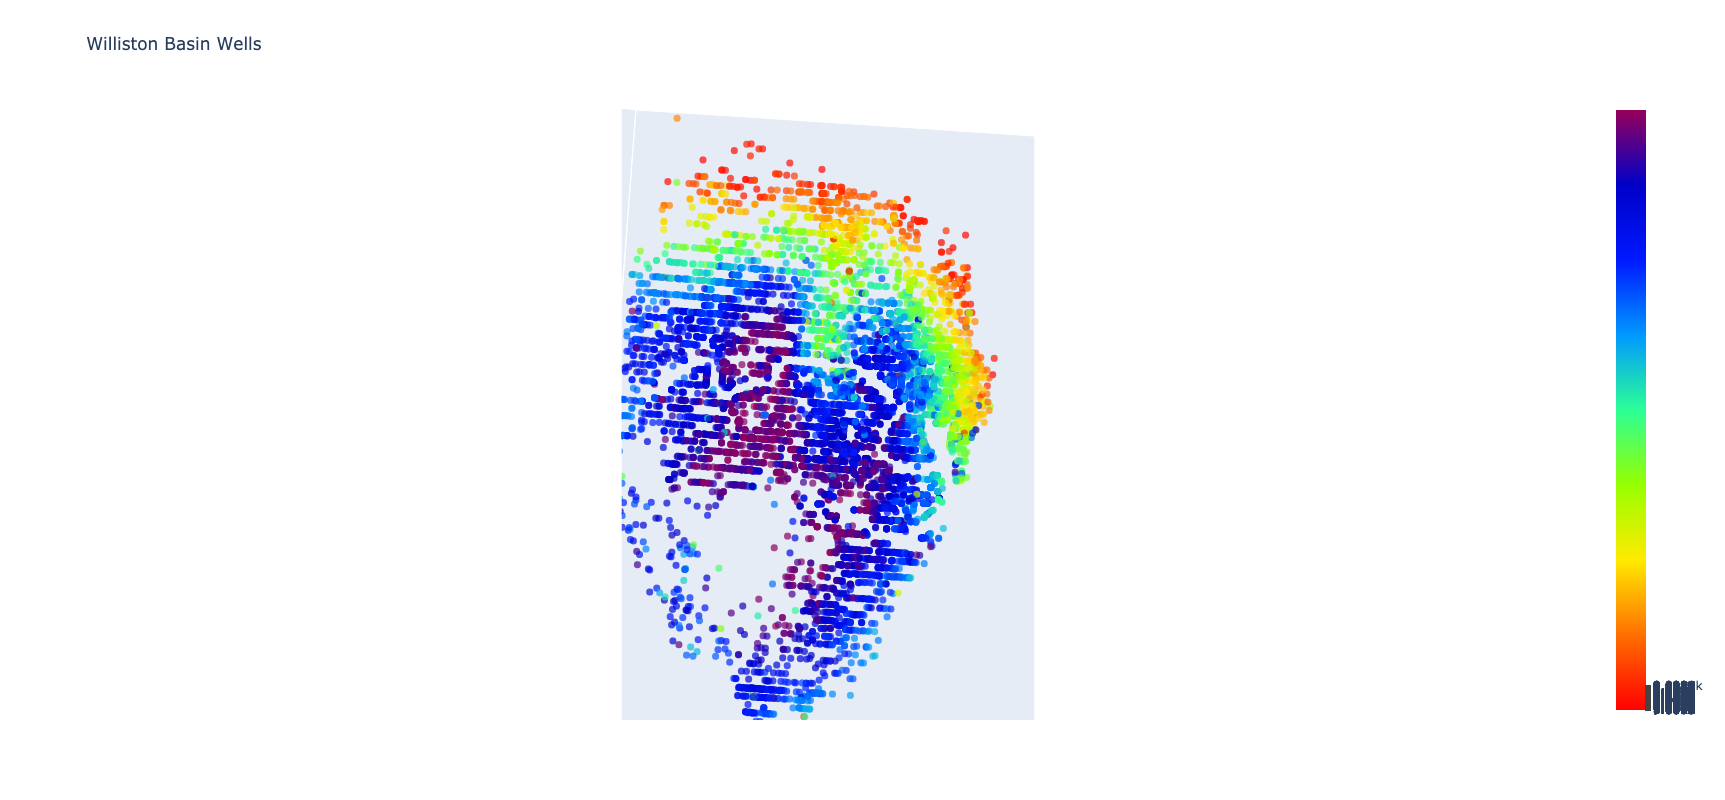

In [10]:
df_sample = df_header[df_header['Top_Perf'].between(9000,11500)].sample(10000)

fig = go.Figure(data=go.Scattergeo(
    lon = df_sample['Longitude'],
    lat = df_sample['Latitude'],
    text = df_sample[['Well_Name','Top_Perf','Current_Operator']],
    marker = dict(
        color = df_sample['Top_Perf'],
        colorscale = 'rainbow',
        reversescale = True,
        opacity = 0.7,
        size = 7,
        colorbar = dict(
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticks = "outside",
            showticksuffix = "last",
            dtick = 0.1
        )
    )
))

fig.update_layout(
        title = 'Williston Basin Wells',
        geo_scope='usa',width = 1200, height = 800,
    geo = dict()
    )

fig.update_geos(
    center=dict(lon=df_sample['Longitude'].mean(), lat=df_sample['Latitude'].mean()),
    lataxis_range=[df_sample['Latitude'].min(),df_sample['Latitude'].max()], lonaxis_range=[df_sample['Longitude'].min(),df_sample['Longitude'].max()]
               )
  
fig.show()

## What Operator has Produced the Most Oil to Date?

##### Plot

In [ ]:
query = %sql SELECT p.UWI, COUNT(DISTINCT p.UWI) AS 'Wells', SUM(p.Oil) AS 'Cumulative_Oil', h.Current_Operator FROM prod_table p JOIN header_table h ON p.UWI = h.UWI GROUP BY Current_Operator ORDER BY Cumulative_Oil desc LIMIT 8
df = query.DataFrame()

fig = px.bar(df, x='Current_Operator', y='Cumulative_Oil', width = 700, height=500)
fig.show()

## What Operator has Produced the Most Oil for their well count?

In [ ]:
%%sql 

SELECT p.UWI, COUNT(DISTINCT p.UWI) AS 'Wells', SUM(p.Oil) AS 'Cumulative_Oil', h.Current_Operator
FROM prod_table p 
JOIN header_table h 
ON p.UWI = h.UWI 
GROUP BY Current_Operator
ORDER BY Cumulative_Oil desc
LIMIT 8

#### Plot

In [ ]:
query = %sql SELECT p.UWI, COUNT(DISTINCT p.UWI) AS 'Wells', SUM(p.Oil) AS 'Cumulative_Oil', h.Current_Operator FROM prod_table p JOIN header_table h ON p.UWI = h.UWI GROUP BY Current_Operator ORDER BY Cumulative_Oil desc LIMIT 10
df = query.DataFrame()
df['Oil_Per_Well'] = df['Cumulative_Oil'] / df['Wells']
df.sort_values('Oil_Per_Well',inplace=True,ascending=False)

fig = px.bar(df, x='Current_Operator', y='Oil_Per_Well', width = 700, height=500)
fig.show()

## Simple Production Plot

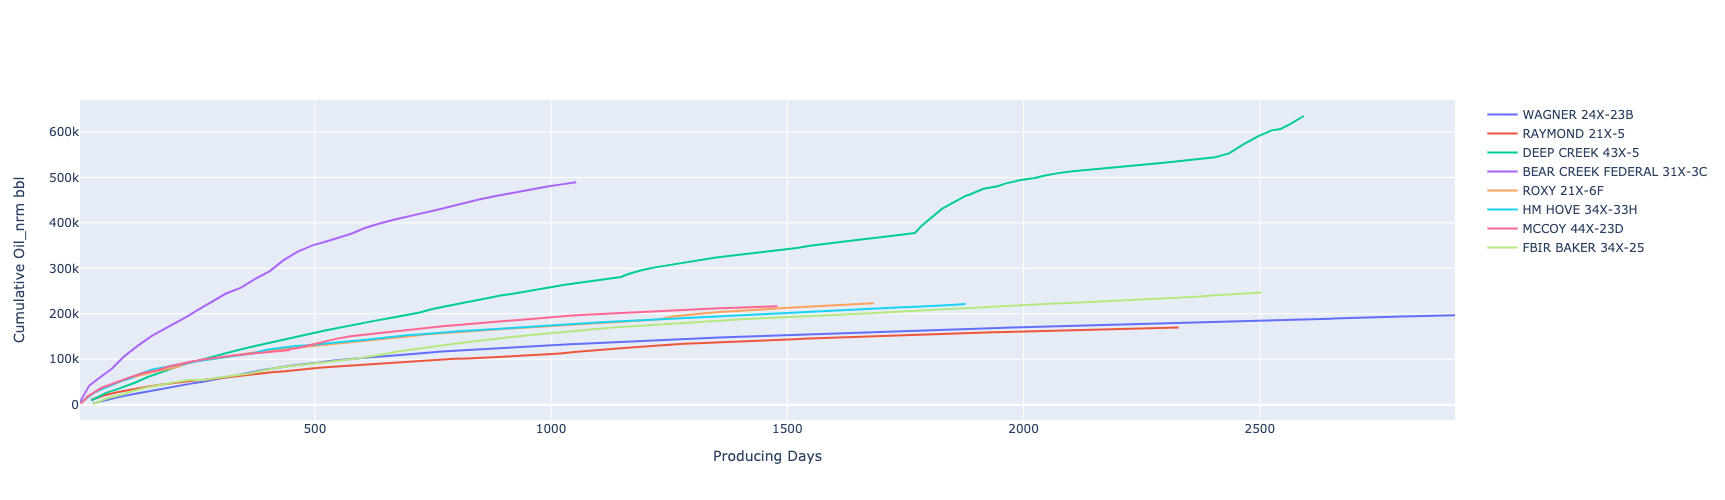

In [15]:
df9 = df_header[df_header['Current_Operator'].str.contains('XTO')].sample(8)
df_prod = df_production.copy()
# ---------------------------------------------------------
STREAM_PLOT(dataframe = df9, 
            production_dataframe = df_prod, 
            material = 'Oil_nrm', 
            cumulative = 1, 
            line_width = 2,
            width = 700, height = 500 )

## Water / Oil Ratio Plot

2008-2012 442 wells
2012-2014 619 wells
2014-2016 452 wells
2016-2018 288 wells
2018-2020 316 wells


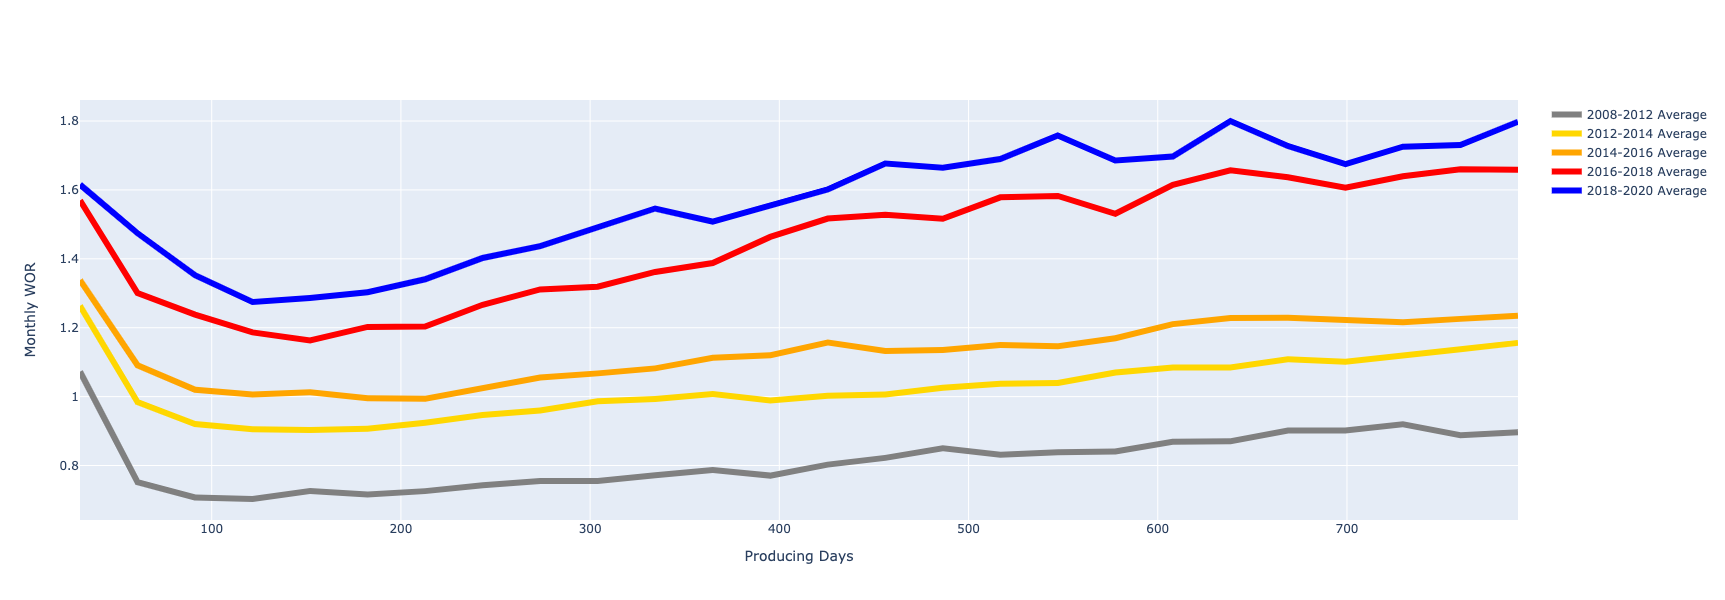

In [16]:
df9 = df_header[df_header['Vintage_Year'] > 2008].sample(1000)
df_prod = df_production[df_production['WOR'].between(0,10)]
# ---------------------------------------------------------
STREAM_PLOT(dataframe = df9, 
            production_dataframe = df_prod, 
            material = 'WOR', 
            cumulative = 0, 
            variable = 'Vintage_Year', 
            variable_dict = {'2008-2012':'grey','2012-2014':'gold','2014-2016':'orange','2016-2018':'red','2018-2020':'blue'},
            averages = 1,
            all_streams = 0,
            width = 800, height = 600 )

## Production by ~Depth / Pressure

0-9000 93 wells
9000-10000 238 wells
10000-11000 922 wells
11000-12000 1224 wells
12000-13000 31 wells


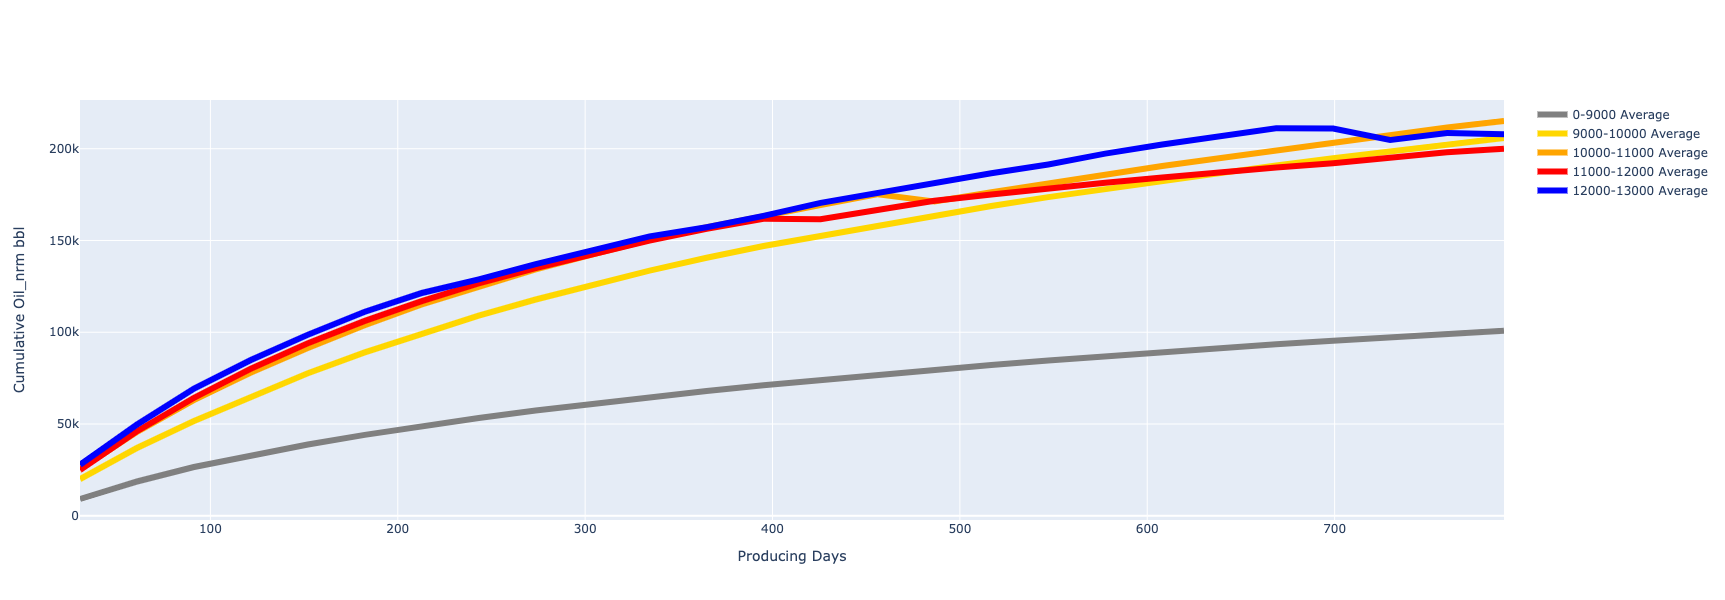

In [20]:
df9 = df_header.sample(2500)
df_prod = df_production.copy()
# ---------------------------------------------------------
STREAM_PLOT(dataframe = df9, 
            production_dataframe = df_prod, 
            material = 'Oil_nrm', 
            cumulative =1, 
            variable = 'Top_Perf', 
            variable_dict = {'0-9000':'grey','9000-10000':'gold','10000-11000':'orange','11000-12000':'red','12000-13000':'blue'},
            averages = 1,
            all_streams = 0,
            width = 800, height = 600 )

## What areas have produced the most oil?

In [ ]:
query = %sql SELECT p.UWI, h.Block, COUNT(DISTINCT p.UWI) AS 'Wells_Per_Block', SUM(p.Oil) AS 'Cumulative_Oil_Per_Block' FROM prod_table_clean p JOIN header_table_clean h ON p.UWI = h.UWI GROUP BY Block ORDER BY Cumulative_Oil_Per_Block desc

df_block = query.DataFrame()
df_block.drop(columns='UWI',inplace=True)
df_block.set_index('Block',inplace=True)
df_block['Cum_Oil_Per_Well_Block'] = df_block['Cumulative_Oil_Per_Block'] / df_block['Wells_Per_Block']
print(len(df_block))
df_block.head()

In [66]:
df_header = df_header.merge(df_block[['Wells_Per_Block','Cumulative_Oil_Per_Block','Cum_Oil_Per_Well_Block']],left_on='Block',right_on='Block')
df_header.sort_values('Cumulative_Oil_Per_Block',inplace=True,ascending=False)
df_header.head()

File_Number           Well_Name Well_Type Well_Status        Location  \
3627        20780  HENDERSON 1-28/33H        OG           A  NENE 28-150-95   
3744        30583    TIPI V 1-24-25TH        OG           A  SESE 13-150-95   
3731        30048    MARLENE 42X-20F2        OG           A  SENE 20-150-95   
3732        30049     MARLENE 42X-20C        OG           A  SENE 20-150-95   
3733        30214   MARLENE 42X-20CXD        OG           A  SENE 20-150-95   

      Latitude  Longitude    Current_Operator Completion_Date Total_Depth  \
3627      47.8     -102.8  QEP ENERGY COMPANY      2012-01-17       20682   
3744      47.8     -102.8  QEP ENERGY COMPANY      2018-04-06       21349   
3731      47.8     -102.9      XTO ENERGY INC      2015-07-25       20917   
3732      47.8     -102.9      XTO ENERGY INC      2015-08-04       20608   
3733      47.8     -102.9      XTO ENERGY INC      2015-07-07       20567   

      ... Perforated_Length Direction        TRS  Section  Township  Range  \
3627  ...            9452.0      NENE  28-150-95       28       150     95   
3744  ...           10202.0      SESE  13-150-95       13       150     95   
3731  ...            9780.0      SENE  20-150-95       20       150     95   
3732  ...            9651.0      SENE  20-150-95       20       150     95   
3733  ...            9583.0      SENE  20-150-95       20       150     95   

      Block  Wells_Per_Block Cumulative_Oil_Per_Block Cum_Oil_Per_Well_Block  
3627  15095              212                 68701132               324061.9  
3744  15095              212                 68701132               324061.9  
3731  15095              212                 68701132               324061.9  
3732  15095              212                 68701132               324061.9  
3733  15095              212                 68701132               324061.9  

[5 rows x 30 columns]

#### Map

In [ ]:
df_sample = df_header[df_header['Top_Perf'].between(9000,11500)]

fig = go.Figure(data=go.Scattergeo(
    lon = df_sample['Longitude'],
    lat = df_sample['Latitude'],
    text = df_sample[['Well_Name','Top_Perf','Current_Operator','Block','Cumulative_Oil_Per_Block']],
    marker = dict(
        color = df_sample['Cumulative_Oil_Per_Block'],
        colorscale = 'rainbow',
        reversescale = True,
        opacity = 0.7,
        size = 7,
        colorbar = dict(
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticks = "outside",
            showticksuffix = "last",
            dtick = 0.1
        )
    )
))

fig.update_layout(
        title = 'Williston Basin Wells',
        geo_scope='usa',width = 1200, height = 800,
    geo = dict()
    )

fig.update_geos(
    center=dict(lon=df_sample['Longitude'].mean(), lat=df_sample['Latitude'].mean()),
    lataxis_range=[df_sample['Latitude'].min(),df_sample['Latitude'].max()], lonaxis_range=[df_sample['Longitude'].min(),df_sample['Longitude'].max()]
               )
  
fig.show()

## What areas have produced the most oil per well?

### Map

In [ ]:
df_sample = df_header[df_header['Top_Perf'].between(9000,11500)]

fig = go.Figure(data=go.Scattergeo(
    lon = df_sample['Longitude'],
    lat = df_sample['Latitude'],
    text = df_sample[['Well_Name','Top_Perf','Current_Operator','Block','Cumulative_Oil_Per_Block','Cum_Oil_Per_Well_Block']],
    marker = dict(
        color = df_sample['Cum_Oil_Per_Well_Block'],
        colorscale = 'rainbow',
        reversescale = True,
        opacity = 0.7,
        size = 7,
        colorbar = dict(
            titleside = "right",
            outlinecolor = "rgba(68, 68, 68, 0)",
            ticks = "outside",
            showticksuffix = "last",
            dtick = 0.1
        )
    )
))

fig.update_layout(
        title = 'Williston Basin Wells',
        geo_scope='usa',width = 1200, height = 800,
    geo = dict()
    )

fig.update_geos(
    center=dict(lon=df_sample['Longitude'].mean(), lat=df_sample['Latitude'].mean()),
    lataxis_range=[df_sample['Latitude'].min(),df_sample['Latitude'].max()], lonaxis_range=[df_sample['Longitude'].min(),df_sample['Longitude'].max()]
               )
  
fig.show()